# Galaxy Classifier - Data exploration

The aim of this project is to build a classifier that can infer the type of a galaxy given some input data. THese input data will be two fold:
- We will first build typical machine learning classifiers, such as the KNN, SVM, MLP etc... which take as input some processed numeric data
- In a second part of the project, we will create a convolutional deep neural network that will take as input a raw image of a galaxy

In this first section we use the Galaxy Zoo processed data, and explore its components and properties. The steps are strongly inspired by : https://thecleverprogrammer.com/2020/08/28/galaxy-classification-with-machine-learning/ . I use it now as a tutorial but will soon adapt it. 

The data originate from:

- tables used: https://data.galaxyzoo.org/
- images and explanation : https://zenodo.org/record/3565489#.YBBFLPtKiUl
- context of the Galaxy Zoo project: https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/about/results
- Decision Tree for classification : https://data.galaxyzoo.org/gz_trees/gz_trees.html

## Galaxy Zoo1 Catalog Data

This dataset contains information on galaxy classifications made by participants of the Galaxy Zoo project.
The file can be found at the following URL: <https://galaxy-zoo-1.s3.amazonaws.com/GalaxyZoo1_DR_table2.csv.gz>

This table gives classifications of galaxies which have spectra included in SDSS Data Release 7.
The fraction of the vote in each of the six categories is given, along with debiased votes in elliptical and spiral categories and
flags identifying systems as classified as spiral, elliptical or uncertain.

### Column Descriptions

1. OBJID: Unique identifier of the galaxy in the SDSS catalog.
2. RA: Right Ascension (in degrees) of the galaxy.
3. DEC: Declination (in degrees) of the galaxy.
4. NVOTE: Number of votes obtained for this galaxy.
5. P_EL: Probability that the galaxy is elliptical.
6. P_CW: Probability that the galaxy is a clockwise spiraled galaxy.
7. P_ACW: Probability that the galaxy is a anticlockwise spiraled galaxy.
8. P_EDGE: Probability that the galaxy is a galaxy with a blurred edge.
9. P_DK: Probability that the galaxy is a galaxy with a dominant nucleus.
10. P_MG: Probability that the galaxy is a galaxy with multiple nuclei.
11. P_CS: Probability that the galaxy is a galaxy with strange features.
12. P_EL_DEBIASED: Probability of the elliptical classification, corrected for bias effect.
13. P_CS_DEBIASED: Probability of the classification with strange features, corrected for bias effect.
14. SPIRAL: Number of votes for the "spiral" classification.
15. ELLIPTICAL: Number of votes for the "elliptical" classification.
16. UNCERTAIN: Number of votes for the "uncertain" classification.

Each of these columns is used to describe the classification of a given galaxy by Galaxy Zoo participants.
The P_* columns contain classification probabilities for each type of galaxy, while the SPIRAL, ELLIPTICAL,
and UNCERTAIN columns provide the number of votes for each classification. The P_*_DEBIASED columns are corrected for bias effect.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('../data/GalaxyZoo1_DR_table2.csv')
df.head()

,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
0,587727178986356823,00:00:00.41,-10:22:25.7,59,0.610,0.034,0.000,0.153,0.153,0.051,0.186,0.610,0.186,0,0,1
1,587727227300741210,00:00:00.74,-09:13:20.2,18,0.611,0.000,0.167,0.222,0.000,0.000,0.389,0.203,0.797,1,0,0
2,587727225153257596,00:00:01.03,-10:56:48.0,68,0.735,0.029,0.000,0.147,0.074,0.015,0.176,0.432,0.428,0,0,1
3,587730774962536596,00:00:01.38,+15:30:35.3,52,0.885,0.019,0.000,0.058,0.019,0.019,0.077,0.885,0.077,0,1,0
4,587731186203885750,00:00:01.55,-00:05:33.3,59,0.712,0.000,0.000,0.220,0.068,0.000,0.220,0.640,0.290,0,0,1


**Selection of features**:  
The first column is a unique identifier which cannot be a feature for our model, and the second and third columns are the absolute positions of galaxies. We assume the universe to be homogenous and isotropic, so we will suppose that the position in the sky of the galaxy does not correlate with our classes/targets.

In [13]:
data = df.drop(['OBJID','RA','DEC'], axis=1)

As this is a Galaxy classification model, we have to check the class imbalance in a dataset where we perform classification task, even though its class binary imbalance may have a major effect in the phase training, and ultimately on precision. To plot the value_counts for three-class columns, we can do it like the code below:

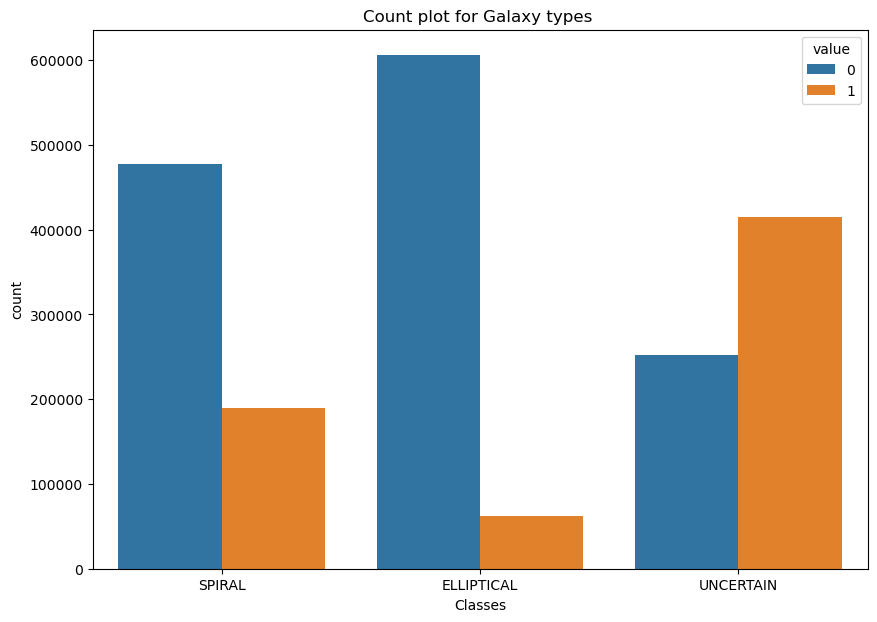

In [14]:
plt.figure(figsize=(10,7))
plt.title('Count plot for Galaxy types ')
countplt = data[['SPIRAL','ELLIPTICAL','UNCERTAIN']]
sns.countplot(x="variable", hue='value', data=pd.melt(countplt))
plt.xlabel('Classes')
plt.show()

## Scaling the data

5th percentile: 22.0, 95th percentile: 64.0


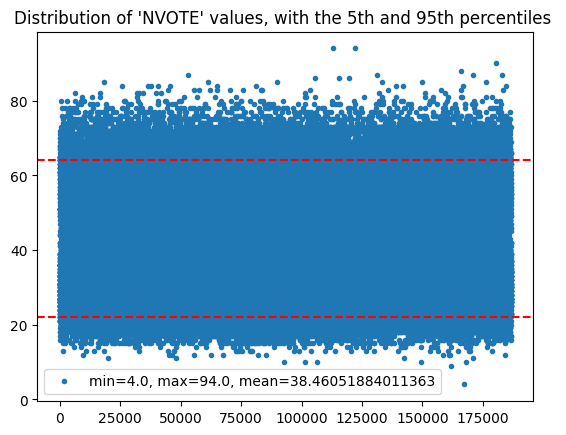

In [24]:
from lblearn.datasets import load_galaxies

data = load_galaxies().data

NVOTE = data[:, 0]
low_percentil = 5
high_percentil = 95

q1 = np.percentile(NVOTE, low_percentil)
q2 = np.percentile(NVOTE, high_percentil)
print(f"{low_percentil}th percentile: {q1}, {high_percentil}th percentile: {q2}")

plt.figure()
plt.title("Distribution of 'NVOTE' values, with the 5th and 95th percentiles ")
plt.plot(NVOTE, '.', label=f'min={NVOTE.min()}, max={NVOTE.max()}, mean={NVOTE.mean()}')
plt.legend()
plt.axhline(y=q1, color='red', linestyle='--')
plt.axhline(y=q2, color='red', linestyle='--');

The `NVOTE` feature of our dataset has a very different scale and contains some outliers. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.

Indeed many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based and gradient-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.
(ref: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

### Standard Scaler

Standard scaler removes the mean and scales the data to unit variance. The scaling shrinks the range of the feature values. However, the outliers have an influence when computing the empirical mean and standard deviation. Standard scaler therefore cannot guarantee balanced feature scales in the presence of outliers.

### Min Max Scaler
Min-Max Scaler rescales the data set such that all feature values are in the range [0, 1]. However, this scaling compresses all inliers.

Both standard scaler and min-max scaler are very sensitive to the presence of outliers.

### Max Abs Scaler

Max Abs Scaler is similar to Min-Max Scaler except that the values are mapped across several ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. On positive only data, both MinMaxScaler and MaxAbsScaler behave similarly. MaxAbsScaler therefore also suffers from the presence of large outliers.

### Robust Scaler

Unlike the previous scalers, the centering and scaling statistics of RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers. Note that the outliers themselves are still present in the transformed data.

### Power Transformer

Power Transformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. Currently the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling factor is determined via maximum likelihood estimation in both methods. By default, PowerTransformer applies zero-mean, unit variance normalization. Note that Box-Cox can only be applied to strictly positive data.

### Quantile Transformer 

QuantileTransformer applies a non-linear transformation such that the probability density function of each feature will be mapped to a uniform or Gaussian distribution. In this case, all the data, including outliers, will be mapped to a uniform distribution with the range [0, 1], making outliers indistinguishable from inliers.

RobustScaler and QuantileTransformer are robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1). This can result in saturation artifacts for extreme values.

### Normalizer

The Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples.

Given that all of our samples except for `NVOTE` are probilities in the range [0, 1], setting all vectors to the same legnth seems to be the best way to normalize our data before training. The normalizer seems the best option in our case.

## Treated dataset

To resume, we have an unbalanced dataset with a sample having large values and outliers. Also, we chose to remove from the training the OBJID, as well as the position of the galaxy in the sky. 
We rescale our dataset so the vector for each sample have unit norm. I have created a helper function to get a balanced dataset, and to reduce the classes to one column, taking values from 0 to 2. The label 0 corresponds to a spiral galaxy and the label 1 an elliptical one.

In [26]:
from lblearn.datasets import load_galaxies
import pandas as pd

In [49]:
galaxies = load_galaxies(n_samples=100) # We can choose how many datapoints we want from each galaxy type

df = pd.DataFrame(galaxies.data, columns=galaxies.feature_names)
df['class'] = galaxies.target
df

,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,class
0,34.0,0.235,0.147,0.441,0.176,0.000,0.000,0.765,0.054,0.946,0
1,27.0,0.370,0.037,0.185,0.333,0.074,0.000,0.556,0.146,0.763,0
2,29.0,0.448,0.069,0.034,0.379,0.069,0.000,0.483,0.074,0.817,0
3,32.0,0.812,0.031,0.000,0.156,0.000,0.000,0.188,0.349,0.651,0
4,54.0,0.463,0.296,0.056,0.185,0.000,0.000,0.537,0.212,0.788,0
...,...,...,...,...,...,...,...,...,...,...,...
295,36.0,0.583,0.028,0.028,0.139,0.222,0.000,0.194,0.583,0.194,2
296,31.0,0.484,0.000,0.000,0.065,0.065,0.387,0.065,0.440,0.091,2
297,60.0,0.767,0.083,0.000,0.050,0.100,0.000,0.133,0.704,0.193,2
298,31.0,0.323,0.419,0.032,0.226,0.000,0.000,0.677,0.100,0.900,2
